In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
from scipy.stats import binned_statistic_2d
from old_sa import calc_errors

In [ ]:
# ALL CCR

# # exp_dir="./experiments/exp_1/sa_results/b95bdbdc-c398-4c15-8b61-6b9f73c95164"     # LAI, rootBeta, n = 1000
# exp_dir="experiments/exp_5/sa_results/20250609_144639"      # LAI, rootBeta, baperga, height, n = 8192 (no errors and all nan indices)
# exp_dir="experiments/exp_8/sa_results/20250610_210610" # fieldCapFrac, fieldCapPercInit
# exp_dir="experiments/exp_8/sa_results/20250611_005112" # fieldCapFrac, fieldCapPercInit, rootbeta
# exp_dir="experiments/exp_9/sa_results/20250610_210151" # experiment 9
# exp_dir="experiments/exp_9/sa_results/20250618_143851" # experiment 9 (more samples)
# exp_dir="experiments/ccr/exp_11/sa_results/20250620_130119" # experiment 11
exp_dir="experiments/ccr/exp_12/sa_results/20250624_115755" # experiment 12

# ALL JLA
# exp_dir="experiments/jla/exp_1/sa_results/20250626_110406" # experiment 1
# exp_dir="experiments/jla/exp_3/sa_results/20250701_131206" # experiment 3

# NRV
# exp_dir="experiments/nrv/exp_1/sa_results/20250701_152341"

In [3]:
with open(f"{exp_dir}/problem.json") as f:
    problem = json.load(f)
out = np.load(f"{exp_dir}/model_output.npy")
out = np.nan_to_num(out)  # Replace NaN values with 0
sample = np.load(f"{exp_dir}/sample.npy")
indices = np.load(f"{exp_dir}/total_order_indices.npy")
indices = np.nan_to_num(indices)

try:
    error_indices = np.load(f"{exp_dir}/error_total_order_indices.npy")
except:
    error_indices = None

try:
    with open(f"{exp_dir}/errors.json") as f:
        errors = json.load(f)
except IOError: # Just incase an error occurs when loading/never calculated in sa.py
    match problem['arguments']['pop']:
        case 1:
            ground = pd.read_csv("data/ccr_hourly_data.csv")
            leaftemp = pd.read_csv("data/ccr_leaftemp.csv")
        case 2:
            ground = pd.read_csv("data/jla_hourly_data.csv")
            leaftemp = pd.read_csv("data/jla_leaftemp.csv")
        case 3:
            ground = pd.read_csv("data/tsz_hourly_data.csv")
            leaftemp = pd.read_csv("data/tsz_leaftemp.csv")
        case 4:
            ground = pd.read_csv("data/nrv_hourly_data.csv")
            leaftemp = pd.read_csv("data/nrv_leaftemp.csv")
        case _:
            raise Exception("Incorrect POP_NUM!")
    errors = calc_errors(out, ground, leaftemp, problem)
    with open(f"{exp_dir}/errors.json", "w") as f:
        json.dump(errors, f, indent=4)

In [4]:
problem

{'num_vars': 7,
 'names': ['i_baperga',
  'i_height',
  'i_leafAreaIndex',
  'i_rootBeta',
  'i_fieldCapFrac',
  'i_fieldCapPercInit',
  'i_kmaxTree'],
 'bounds': [[38.16, 49.06],
  [1.42, 1.75],
  [0.2192, 7.0008],
  [0, 1],
  [0, 1],
  [0, 100],
  [14, 463]],
 'outputs': ['P-PD', 'P-MD', 'GW', 'K-plant', 'E-MD'],
 'plot_settings': {'start_day': 201,
  'end_day': 237,
  'average': False,
  'metric': 'mape'},
 'arguments': {'input': 'sa_problems/ccr/exp-12_sa-problem.json',
  'output': 'experiments/ccr/exp_12',
  'model': './garisom/02_program_code',
  'workers': 32,
  'samples': 8192,
  'pop': 1,
  'verbose': False}}

In [5]:
T, N, D = out.shape # number of time outputs, number of samples, number of output dimensions
_, I = sample.shape # number of samples, number of input dimensions

In [6]:
t_range = range(0, 888) # predrought range
# t_range = range(0, T)

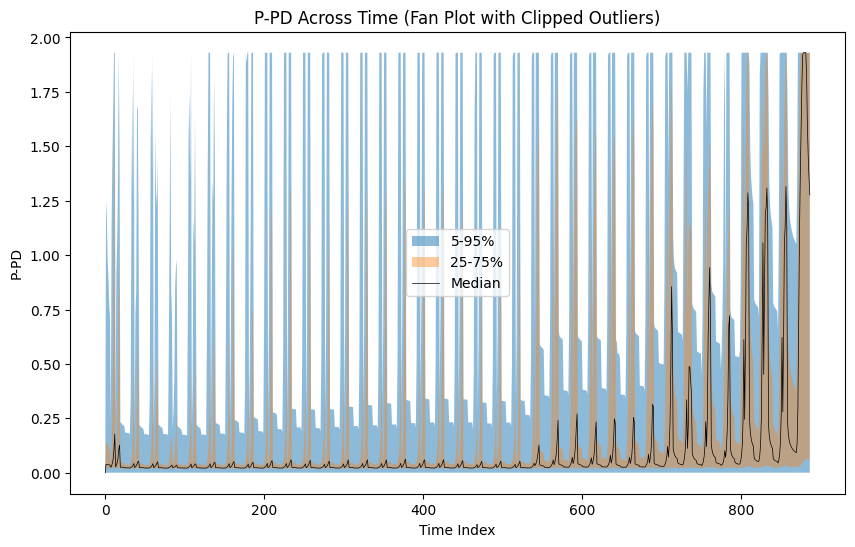

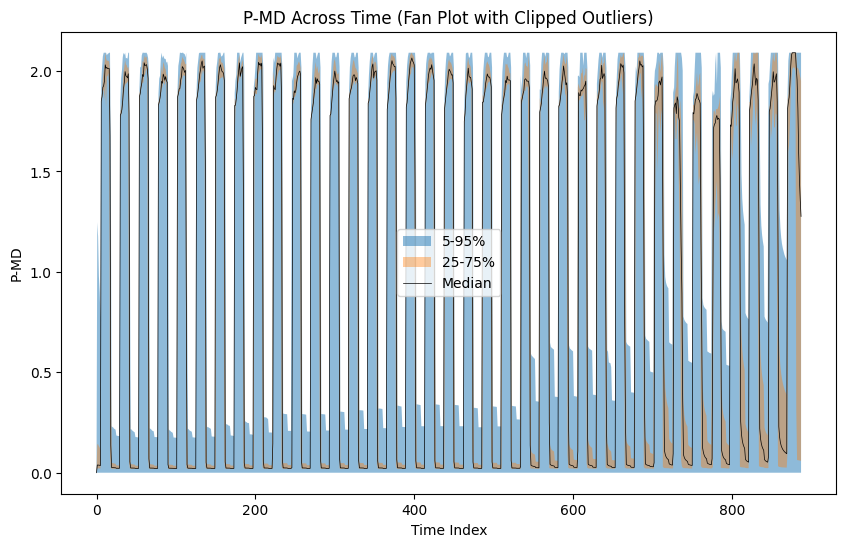

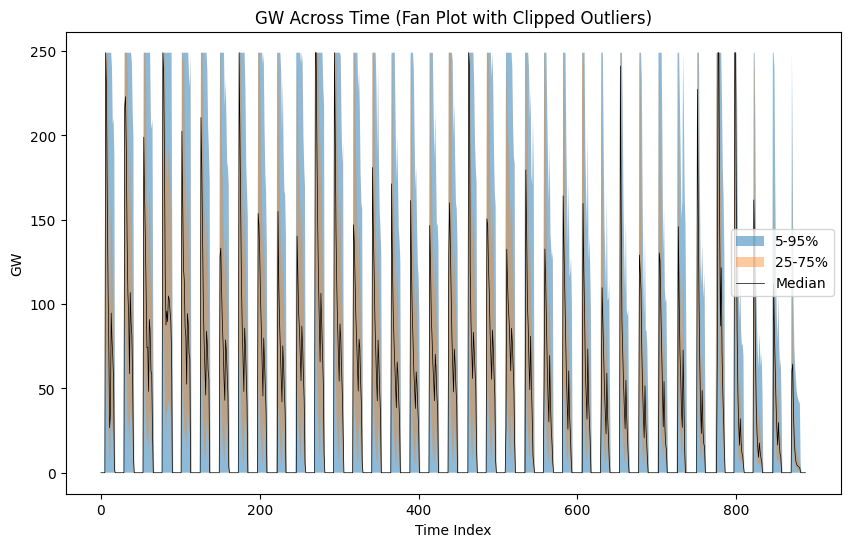

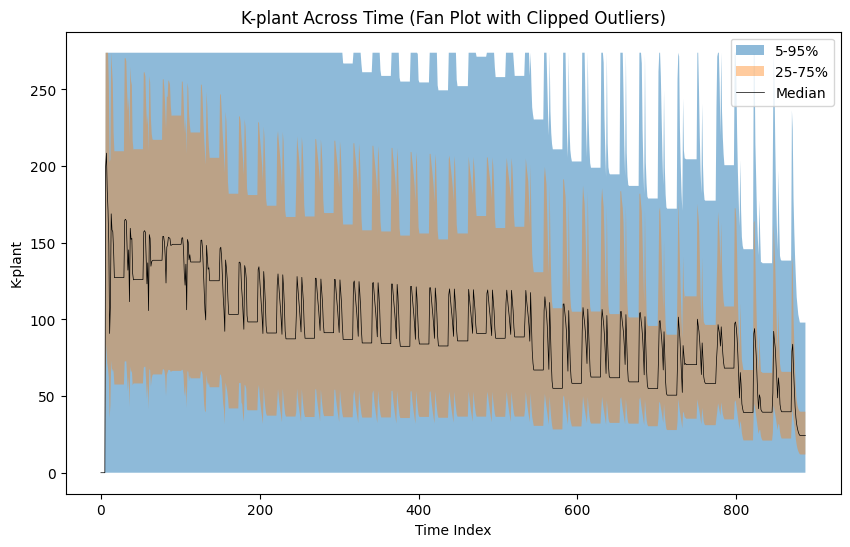

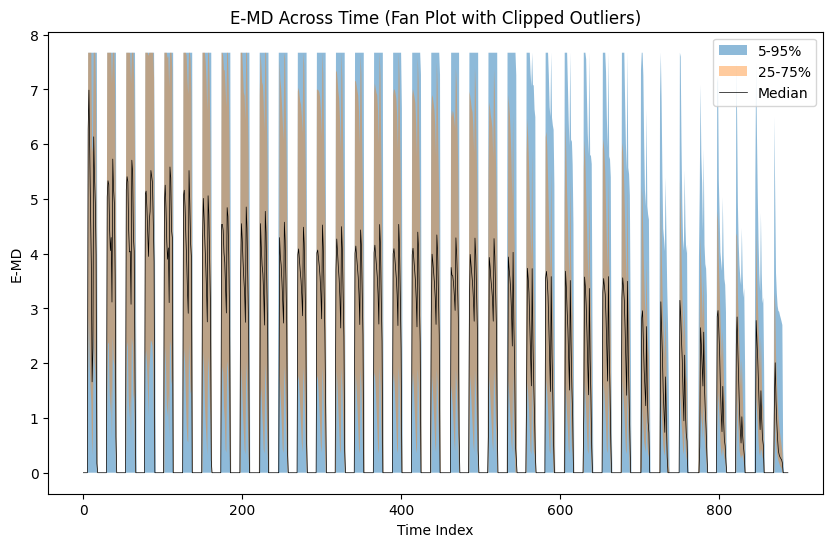

In [7]:
percentiles = [5, 25, 50, 75, 95]

for d in range(D):
    plt.figure(figsize=(10, 6))
    
    # Clip outliers
    clipped_out = np.clip(out[:, :, d], np.percentile(out[:, :, d], 5), np.percentile(out[:, :, d], 95))
    
    # Compute percentiles
    pct = np.percentile(clipped_out, q=percentiles, axis=1)  # shape [len(percentiles), T]
    
    # Fill between percentiles
    # Slice pct to match the length of t_range
    pct_sliced = pct[:, t_range.start:t_range.stop]
    
    plt.fill_between(t_range, pct_sliced[0], pct_sliced[-1], alpha=0.5, label='5-95%')
    plt.fill_between(t_range, pct_sliced[1], pct_sliced[-2], alpha=0.4, label='25-75%')
    
    # Plot median
    plt.plot(t_range, pct_sliced[2], color='black', linewidth=0.5, label='Median')
    
    plt.title(f'{problem["outputs"][d]} Across Time (Fan Plot with Clipped Outliers)')
    plt.xlabel('Time Index')
    plt.ylabel(f'{problem["outputs"][d]}')
    plt.legend()
    plt.show()

In [8]:
# # out: shape (T, N, D)
# # sample: shape (N, I)

# max_ticks = 30  # Reduce number of y-tick labels

# for d in range(D):
#     for i in range(I):
#         plt.figure(figsize=(12, 6))
        
#         # Sort samples by the i-th input parameter
#         sorted_indices = np.argsort(sample[:, i])
#         sorted_param_values = sample[sorted_indices, i]
        
#         # Extract and sort model outputs accordingly
#         output_slice = out[t_range.start:t_range.stop, :, d][:, sorted_indices]  # shape: (T, N)
        
#         # Clip outliers once for the entire slice
#         lower, upper = np.percentile(output_slice, [5, 95])
#         output_slice = np.clip(output_slice, lower, upper)
        
#         # Compute y-tick indices and labels
#         step = max(1, len(sorted_param_values) // max_ticks)
#         y_tick_indices = np.arange(0, len(sorted_param_values), step)
#         y_tick_labels = np.round(sorted_param_values[y_tick_indices], 3)

#         # Plot heatmap
#         ax = sns.heatmap(
#             output_slice.T,  # rows -> y-axis, columns -> x-axis, so transpose
#             cmap='viridis',
#             xticklabels=100,
#             yticklabels=False,
#             cbar_kws={'label': problem['outputs'][d]}
#         )

#         ax.set_yticks(y_tick_indices)
#         ax.set_yticklabels(y_tick_labels, rotation=0, fontsize='small')
        
#         plt.title(f'{problem["outputs"][d]} Across Time\n(sorted by {problem["names"][i]})')
#         plt.xlabel('Time Index')
#         plt.ylabel(f'Input: {problem["names"][i]} Value')
#         plt.tight_layout()
#         plt.show()

In [9]:
# Heatmap averaging over timesteps for unique sample values
# for d in range(D):
#     plt.figure(figsize=(10, 8))

#     # Extract parameter values
#     param_x = sample[:, 0]
#     param_y = sample[:, 1]
#     unique_x = np.unique(param_x)
#     unique_y = np.unique(param_y)

#     # Initialize heatmap data
#     aggregated_output = np.full((len(unique_y), len(unique_x)), np.nan)

#     # Fill heatmap by averaging output at each (x, y) combo
#     # Outputs so y is in row and x is in col
#     for i, x_val in enumerate(unique_x):
#         for j, y_val in enumerate(unique_y):
#             idx = np.where((param_x == x_val) & (param_y == y_val))[0]
#             if len(idx) > 0:
#                 # Filter out zero values in the output array
#                 filtered_out = np.where(out != 0, out, np.nan)
    
#                 # Compute the mean over the specified range and dimension, ignoring NaN values
#                 aggregated_output[j, i] = np.nanmedian(filtered_out[t_range.start:t_range.stop, idx, d])
#                 # aggregated_output[j, i] = np.mean(out[t_range.start:t_range.stop, idx, d])

#     # Optional: clip outliers to improve contrast
#     lower, upper = np.nanpercentile(aggregated_output, [5, 95])
#     aggregated_output = np.clip(aggregated_output, lower, upper)

#     # Reduce number of y-tick and x-tick labels
#     max_ticks = 30
#     step_x = max(1, len(unique_x) // max_ticks)
#     x_tick_indices = np.arange(0, len(unique_x), step_x)
#     x_tick_labels = np.round(unique_x[x_tick_indices], 3)

#     step_y = max(1, len(unique_y) // max_ticks)
#     y_tick_indices = np.arange(0, len(unique_y), step_y)
#     y_tick_labels = np.round(unique_y[y_tick_indices], 3)

#     # Plot
#     ax = sns.heatmap(
#         aggregated_output,
#         xticklabels=False,
#         yticklabels=False,
#         cmap='viridis',
#         cbar_kws={'label': problem['outputs'][d]}
#     )

#     ax.set_yticks(y_tick_indices)
#     ax.set_yticklabels(y_tick_labels, rotation=0, fontsize='small')
    
#     ax.set_xticks(x_tick_indices)
#     ax.set_xticklabels(x_tick_labels, rotation=90, fontsize='small')

#     ax.set_xlabel(f'Input: {problem["names"][0]}')
#     ax.set_ylabel(f'Input: {problem["names"][1]}')
#     ax.set_title(f'{problem["outputs"][d]} across Input Parameters')
#     plt.tight_layout()
#     plt.show()

In [10]:
problem

{'num_vars': 7,
 'names': ['i_baperga',
  'i_height',
  'i_leafAreaIndex',
  'i_rootBeta',
  'i_fieldCapFrac',
  'i_fieldCapPercInit',
  'i_kmaxTree'],
 'bounds': [[38.16, 49.06],
  [1.42, 1.75],
  [0.2192, 7.0008],
  [0, 1],
  [0, 1],
  [0, 100],
  [14, 463]],
 'outputs': ['P-PD', 'P-MD', 'GW', 'K-plant', 'E-MD'],
 'plot_settings': {'start_day': 201,
  'end_day': 237,
  'average': False,
  'metric': 'mape'},
 'arguments': {'input': 'sa_problems/ccr/exp-12_sa-problem.json',
  'output': 'experiments/ccr/exp_12',
  'model': './garisom/02_program_code',
  'workers': 32,
  'samples': 8192,
  'pop': 1,
  'verbose': False}}

In [11]:
# Arguments for graphs
bins = 25
max_ticks = 25
var1 = 3
var2 = 6
metric = 'mape' # mse, mape, made, rmse, r2

# Extract parameter values
# x = sample[:, var1]
# y = sample[:, var2]

In [12]:
# # Binned heatmap aggregating over the outputs and interpolating
# for d in range(D):
#     plt.figure(figsize=(10, 8))

#     # Filter out zero values and clip in the output array
#     filtered_out = np.where(out != 0, out, np.nan)
#     # filtered_out = np.clip(filtered_out, np.nanpercentile(filtered_out, 5), np.nanpercentile(filtered_out, 95))
    
#     # Compute the median over the specified range and dimension, ignoring NaN values
#     z = np.nanmedian(filtered_out[t_range.start:t_range.stop, :, d], axis=0)

#     # Compute mean within bins (parameter values)
#     stat, x_edges, y_edges, binnumber = binned_statistic_2d(
#         x, y, z, statistic='mean', bins=bins
#     )

#     # Reduce number of y-tick and x-tick labels
#     step_x = max(1, len(x_edges) // max_ticks)
#     x_tick_indices = np.arange(0, len(x_edges) - 1, step_x)
#     x_tick_labels = np.round((x_edges[x_tick_indices] + x_edges[x_tick_indices + 1]) / 2, 2)

#     step_y = max(1, len(y_edges) // max_ticks)
#     y_tick_indices = np.arange(0, len(y_edges) - 1, step_y)
#     y_tick_labels = np.round((y_edges[y_tick_indices] + y_edges[y_tick_indices + 1]) / 2, 2)

#     # Plot
#     ax = sns.heatmap(
#         stat.T,
#         xticklabels=False,
#         yticklabels=False,
#         cmap='viridis',
#         cbar_kws={'label': problem['outputs'][d]}
#     )

#     ax.set_yticks(y_tick_indices)
#     ax.set_yticklabels(y_tick_labels, rotation=0, fontsize='small')
    
#     ax.set_xticks(x_tick_indices)
#     ax.set_xticklabels(x_tick_labels, rotation=90, fontsize='small')

#     ax.set_xlabel(f'Input: {problem["names"][var1]}')
#     ax.set_ylabel(f'Input: {problem["names"][var2]}')
#     ax.set_title(f'{problem["outputs"][d]} across Input Parameters')
#     plt.tight_layout()
#     plt.show()

In [13]:
# # Binned heatmap over errors, aggregating over the outputs and interpolating
# for d in range(D):
#     plt.figure(figsize=(10, 8))

#     col = problem['outputs'][d]

#     z = errors[col][metric]
    
#     # Compute mean within bins
#     stat, x_edges, y_edges, binnumber = binned_statistic_2d(
#         x, y, z, statistic='mean', bins=bins
#     )

#     # Reduce number of y-tick and x-tick labels
#     step_x = max(1, len(x_edges) // max_ticks)
#     x_tick_indices = np.arange(0, len(x_edges) - 1, step_x)
#     x_tick_labels = np.round((x_edges[x_tick_indices] + x_edges[x_tick_indices + 1]) / 2, 2)

#     step_y = max(1, len(y_edges) // max_ticks)
#     y_tick_indices = np.arange(0, len(y_edges) - 1, step_y)
#     y_tick_labels = np.round((y_edges[y_tick_indices] + y_edges[y_tick_indices + 1]) / 2, 2)

#     # Plot
#     ax = sns.heatmap(
#         stat.T,
#         xticklabels=False,
#         yticklabels=False,
#         cmap='viridis',
#         cbar_kws={'label': f"{metric} of {problem['outputs'][d]}"}
#     )

#     ax.set_yticks(y_tick_indices)
#     ax.set_yticklabels(y_tick_labels, rotation=0, fontsize='small')
    
#     ax.set_xticks(x_tick_indices)
#     ax.set_xticklabels(x_tick_labels, rotation=90, fontsize='small')

#     ax.set_xlabel(f'Input: {problem["names"][var1]}')
#     ax.set_ylabel(f'Input: {problem["names"][var2]}')
#     ax.set_title(f'{metric} of {problem["outputs"][d]} between Ground and Pred across Input Parameters')
#     plt.tight_layout()
#     plt.show()

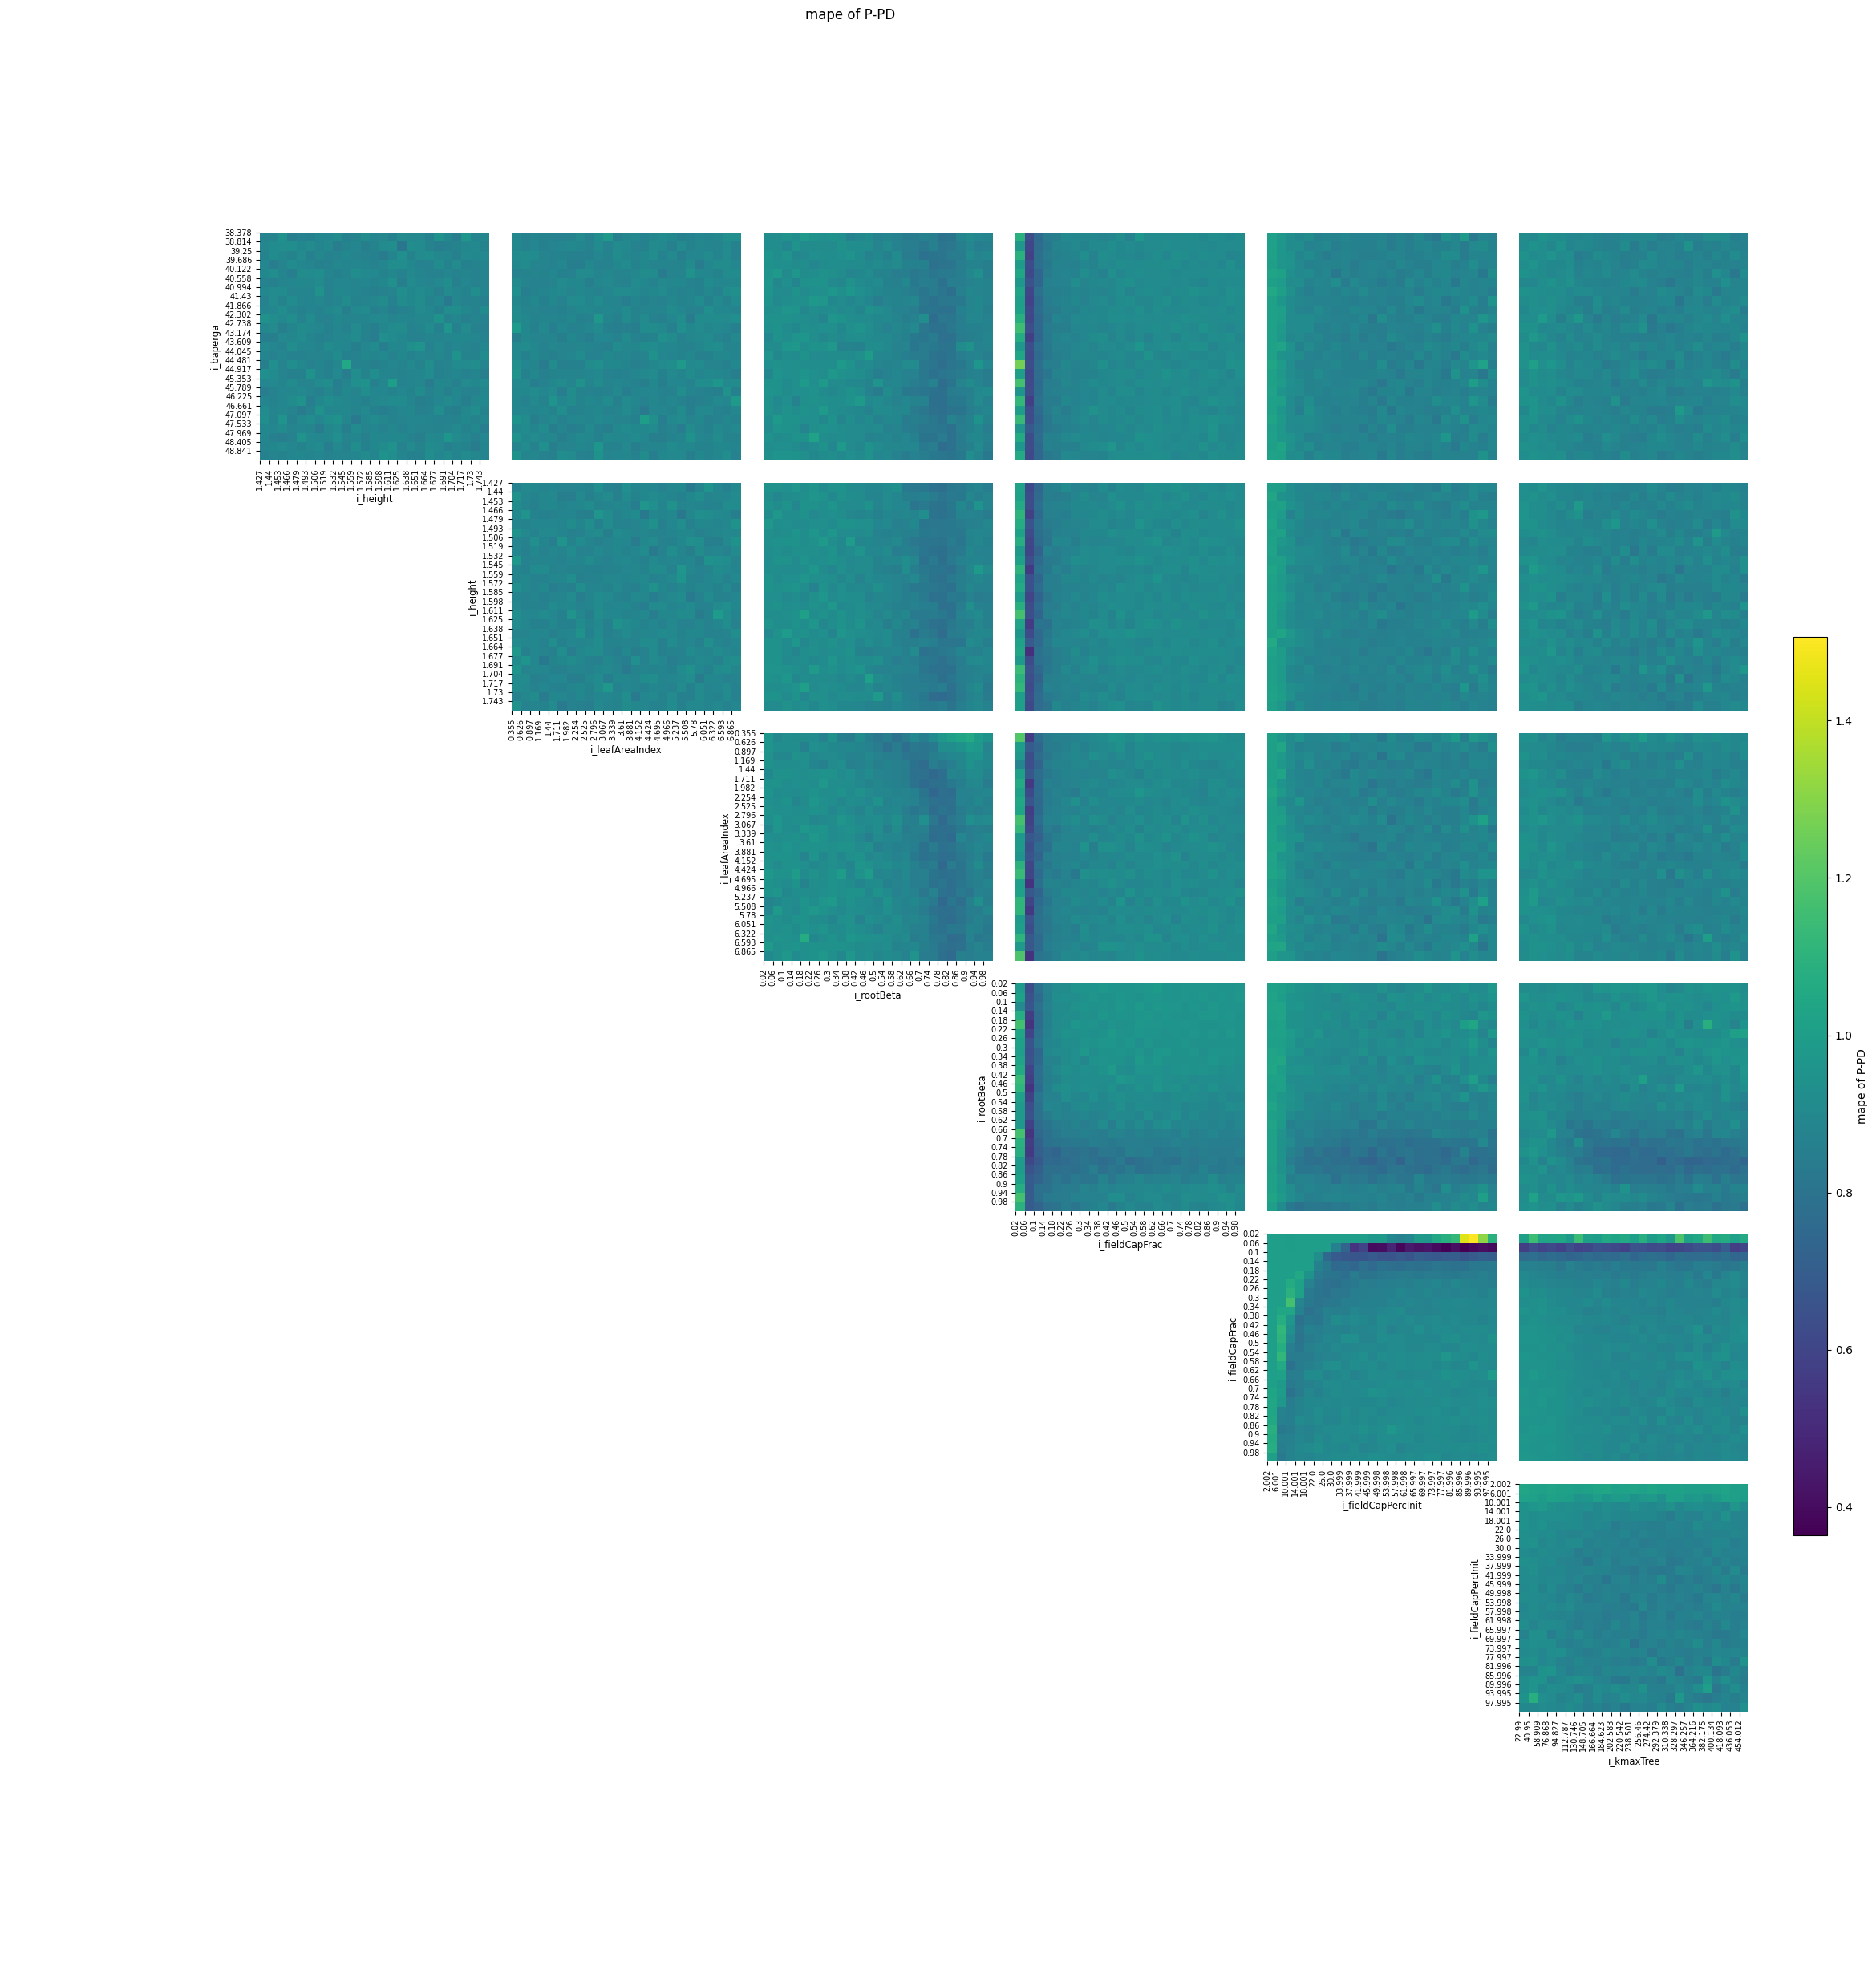

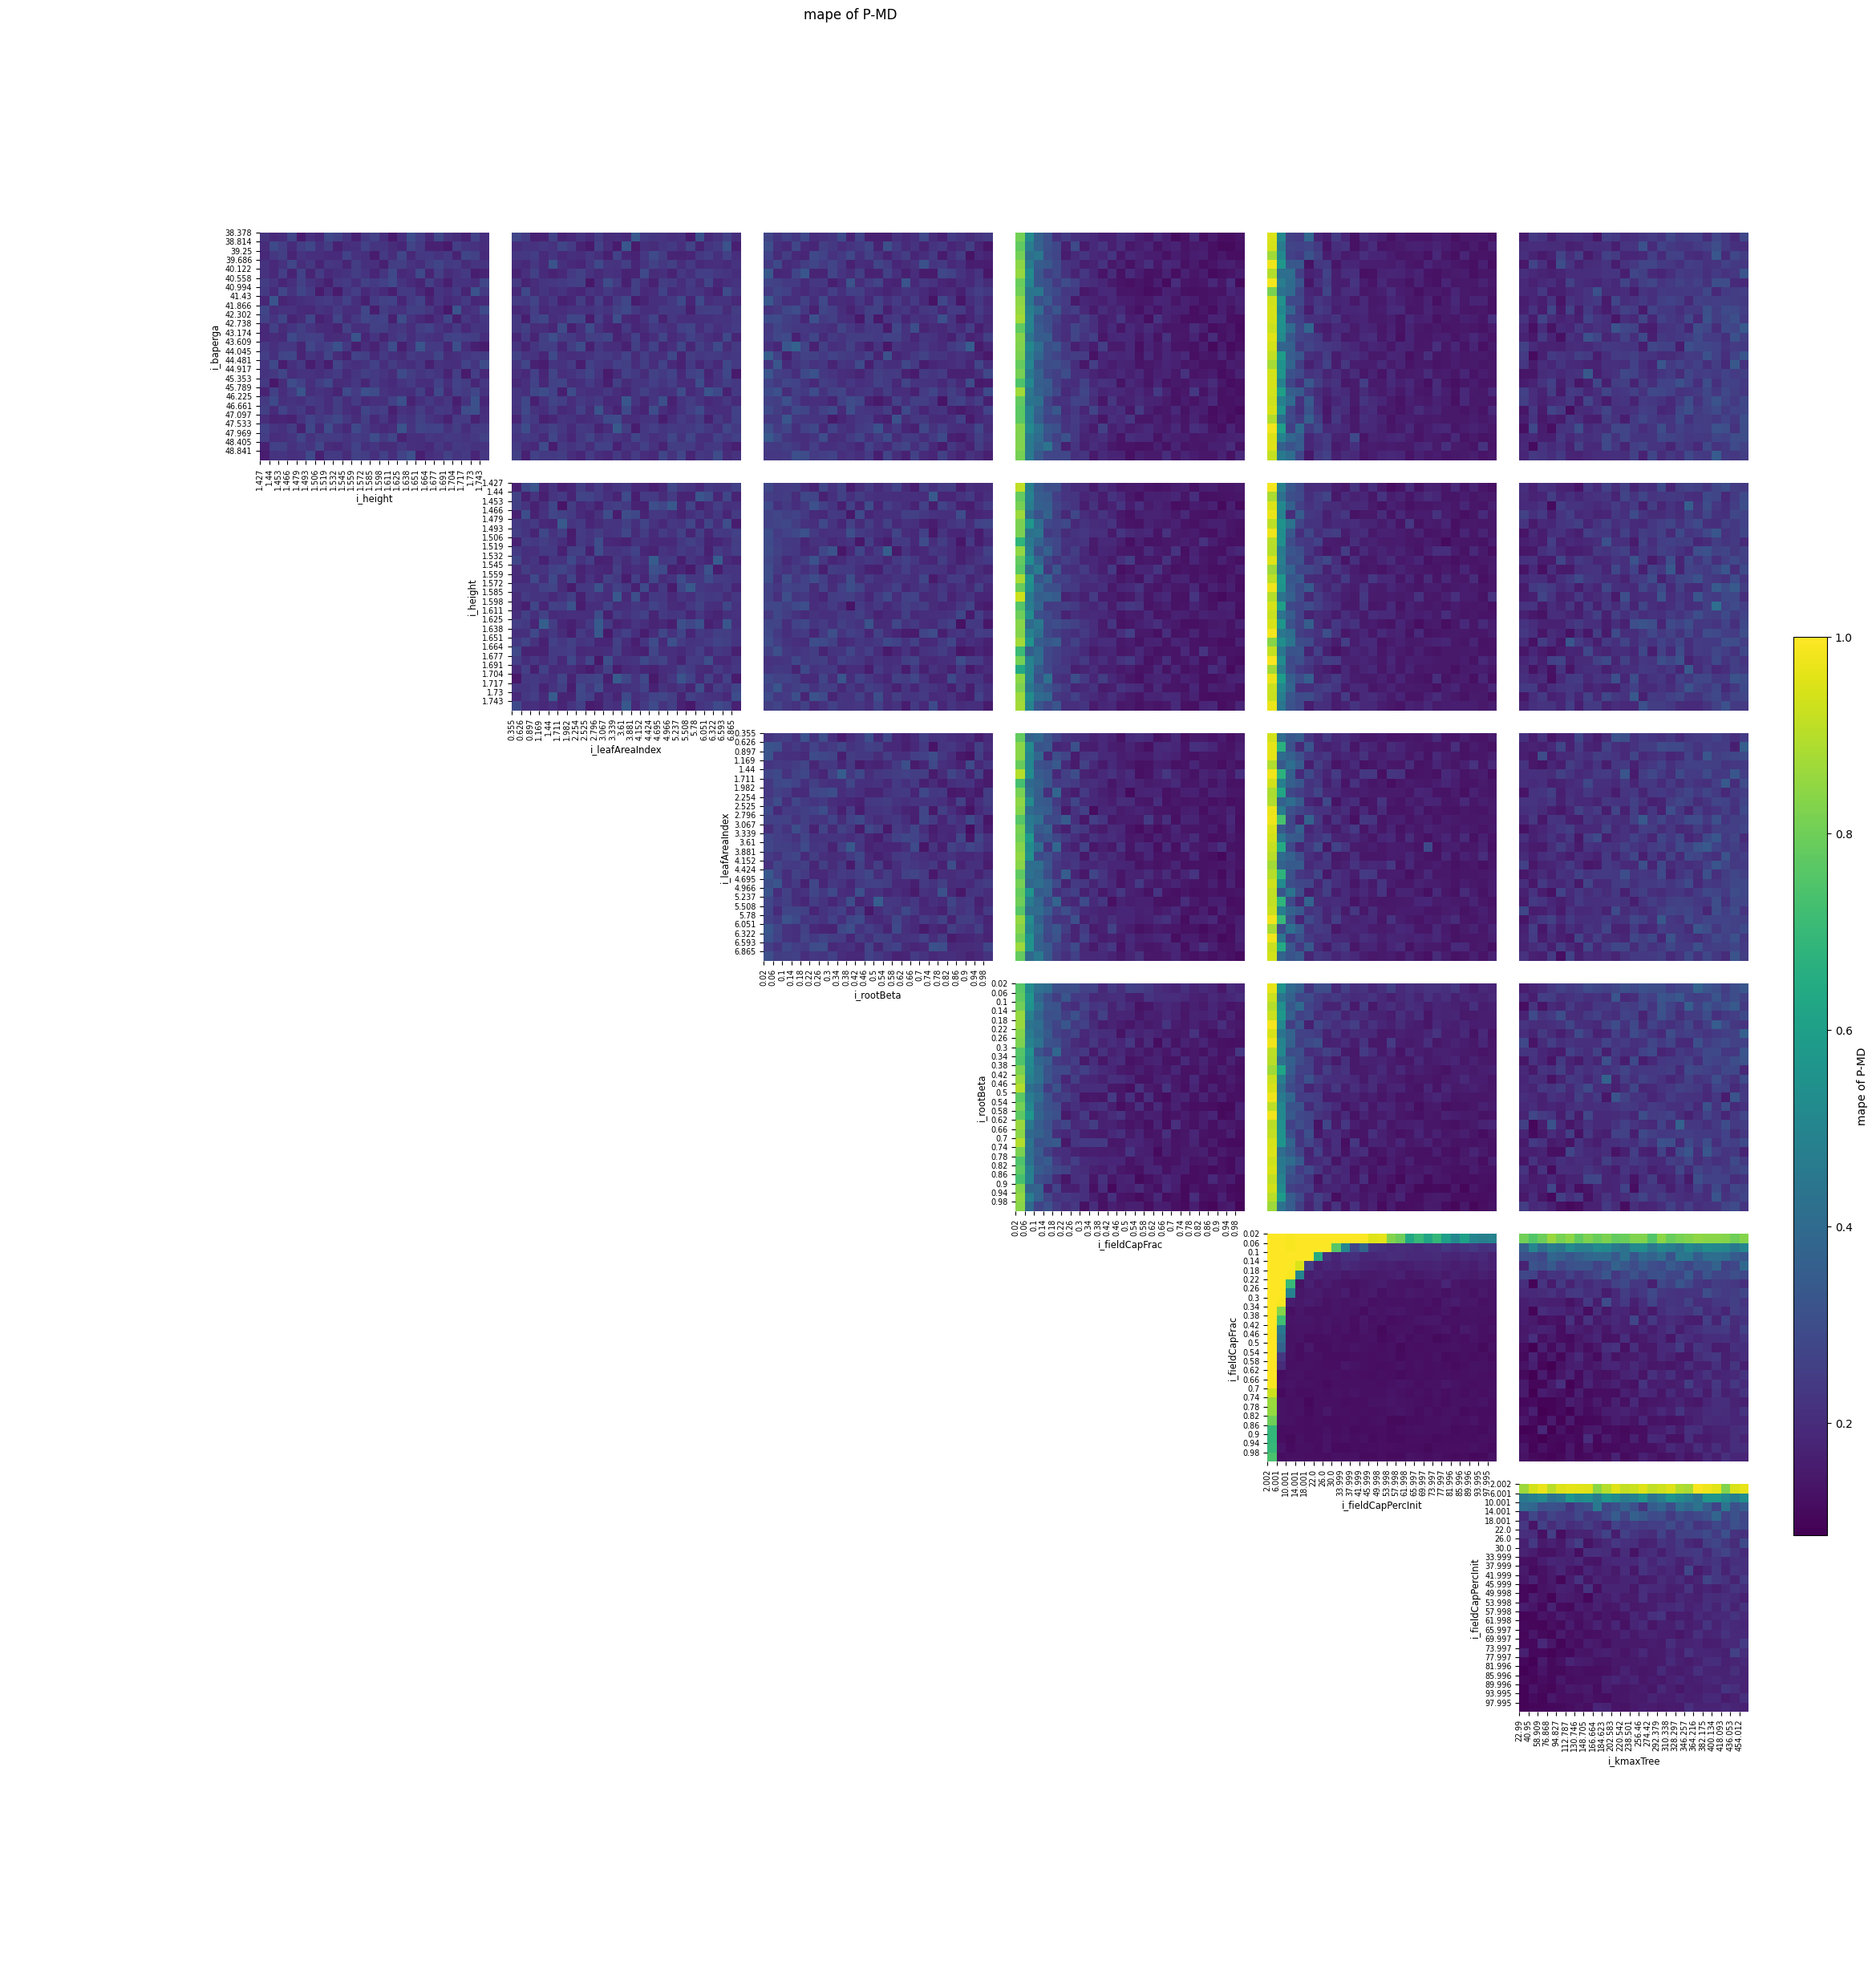

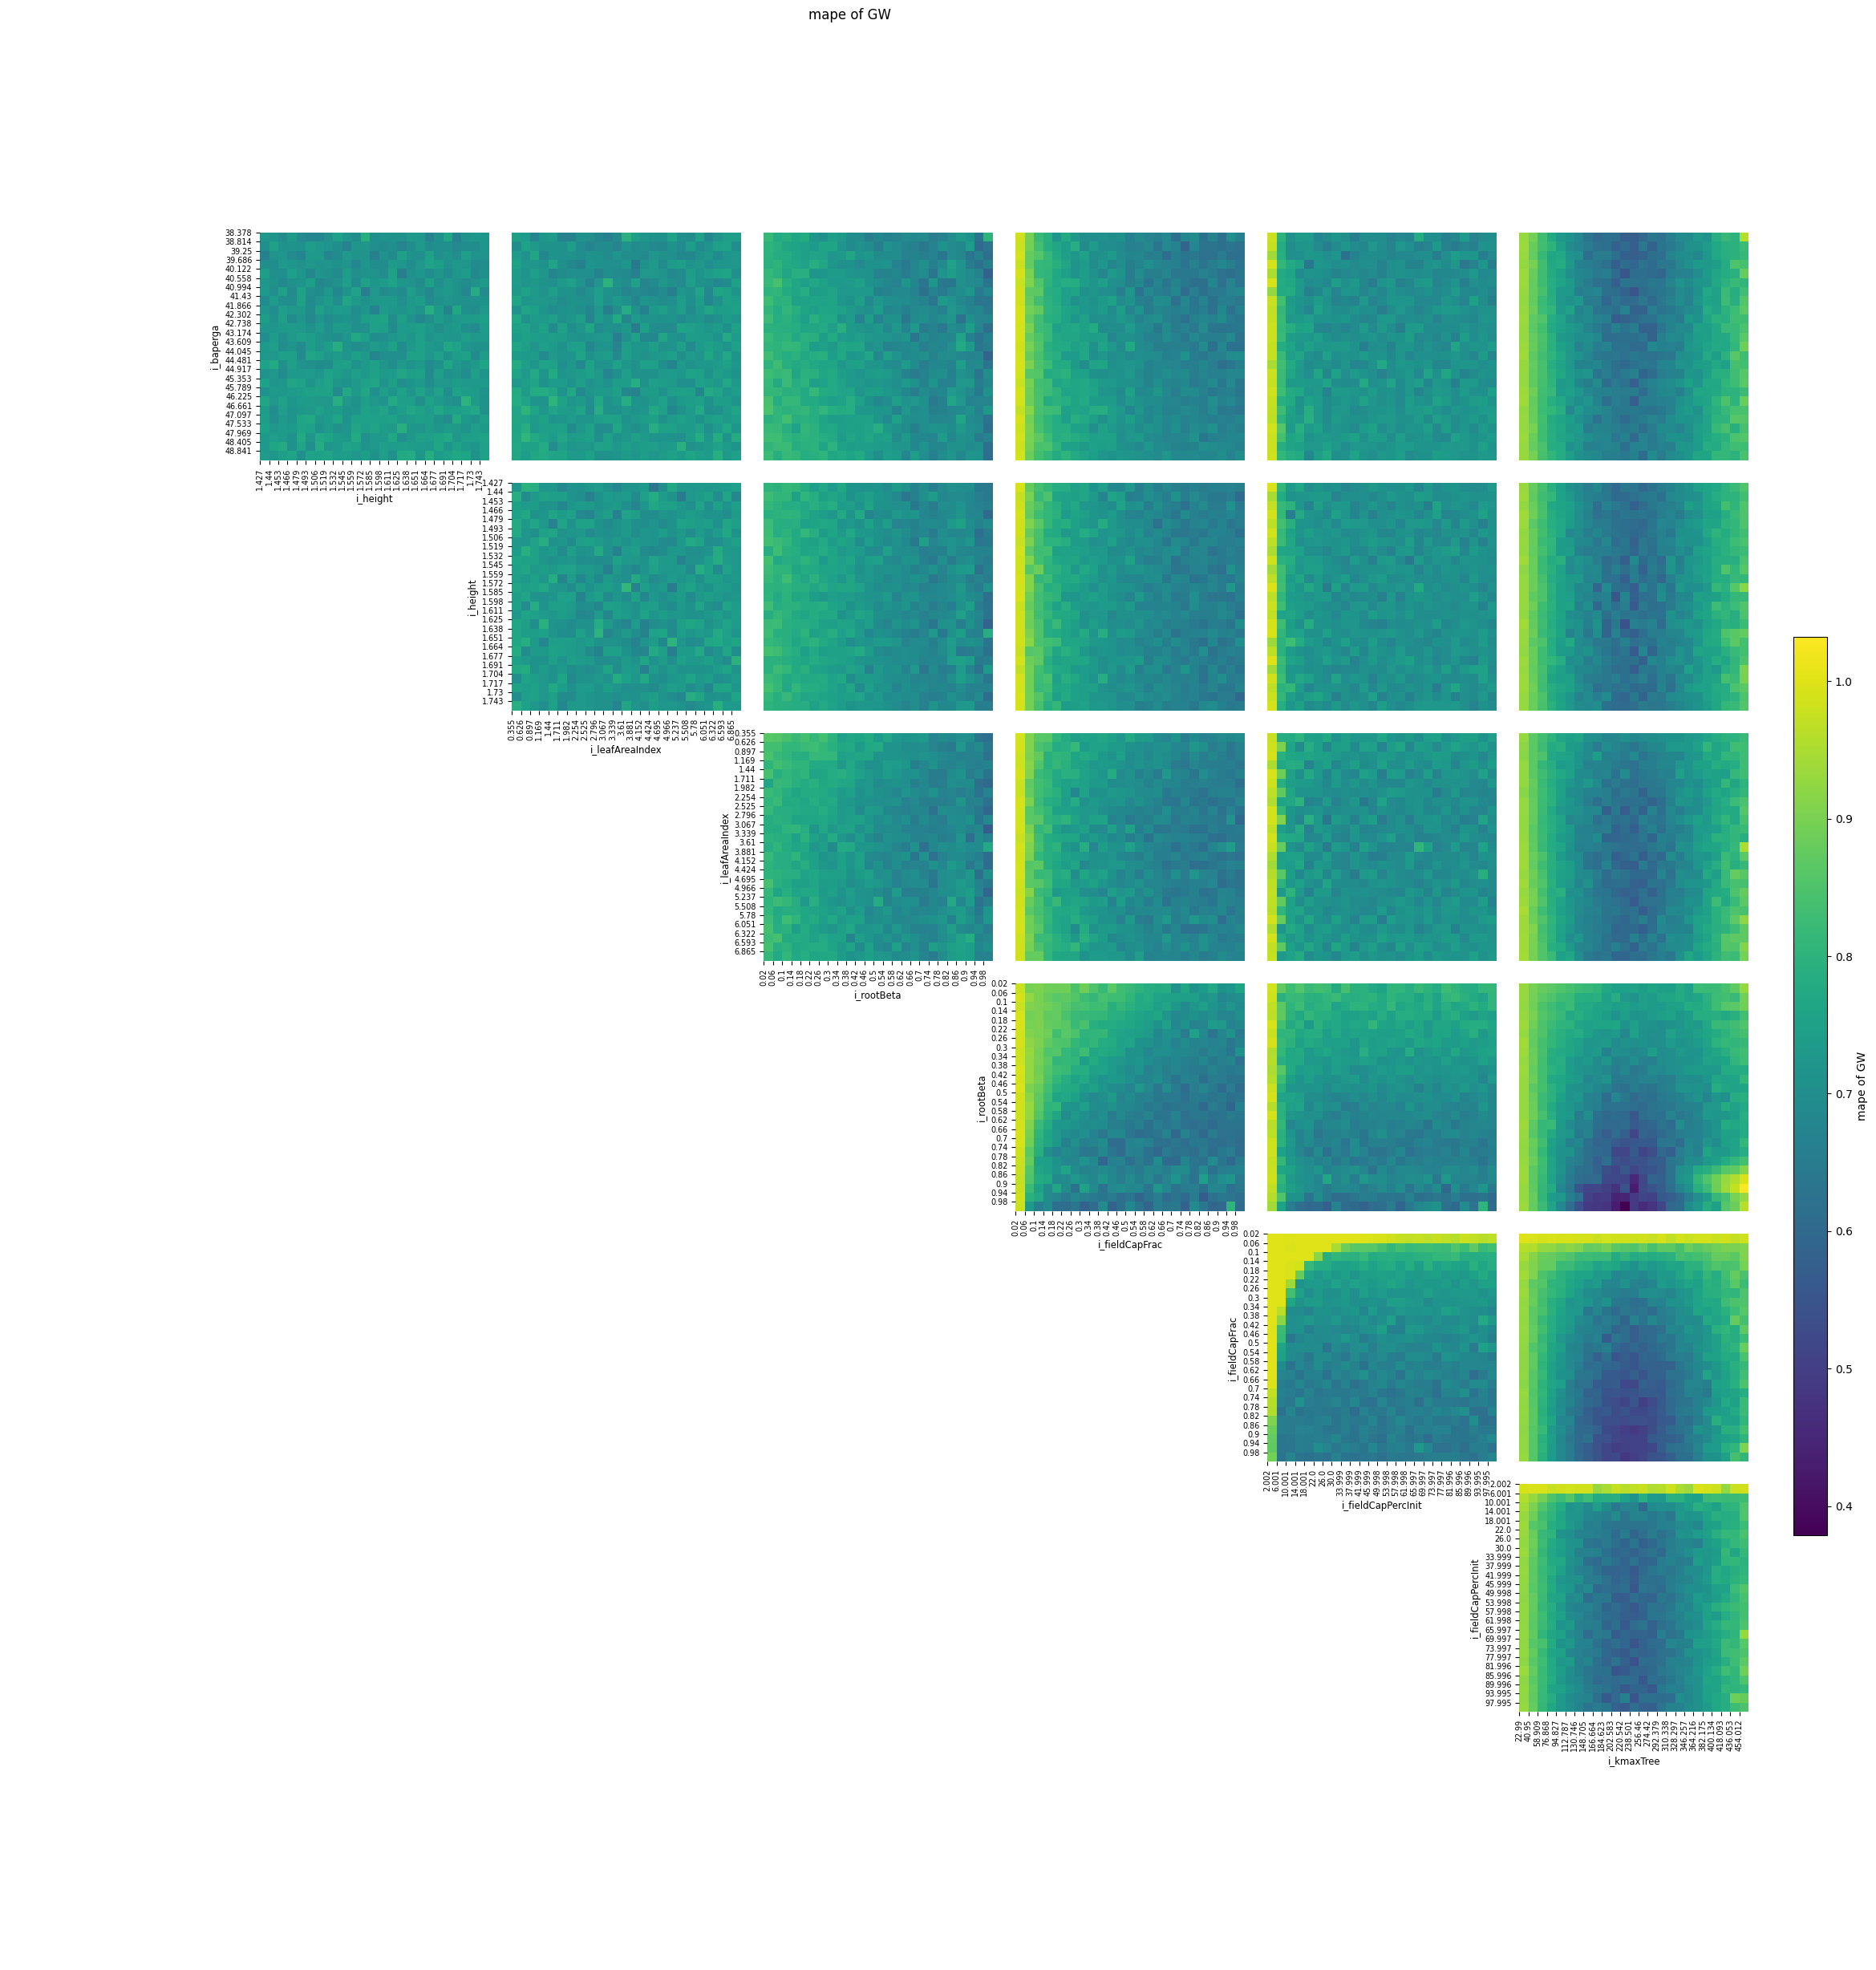

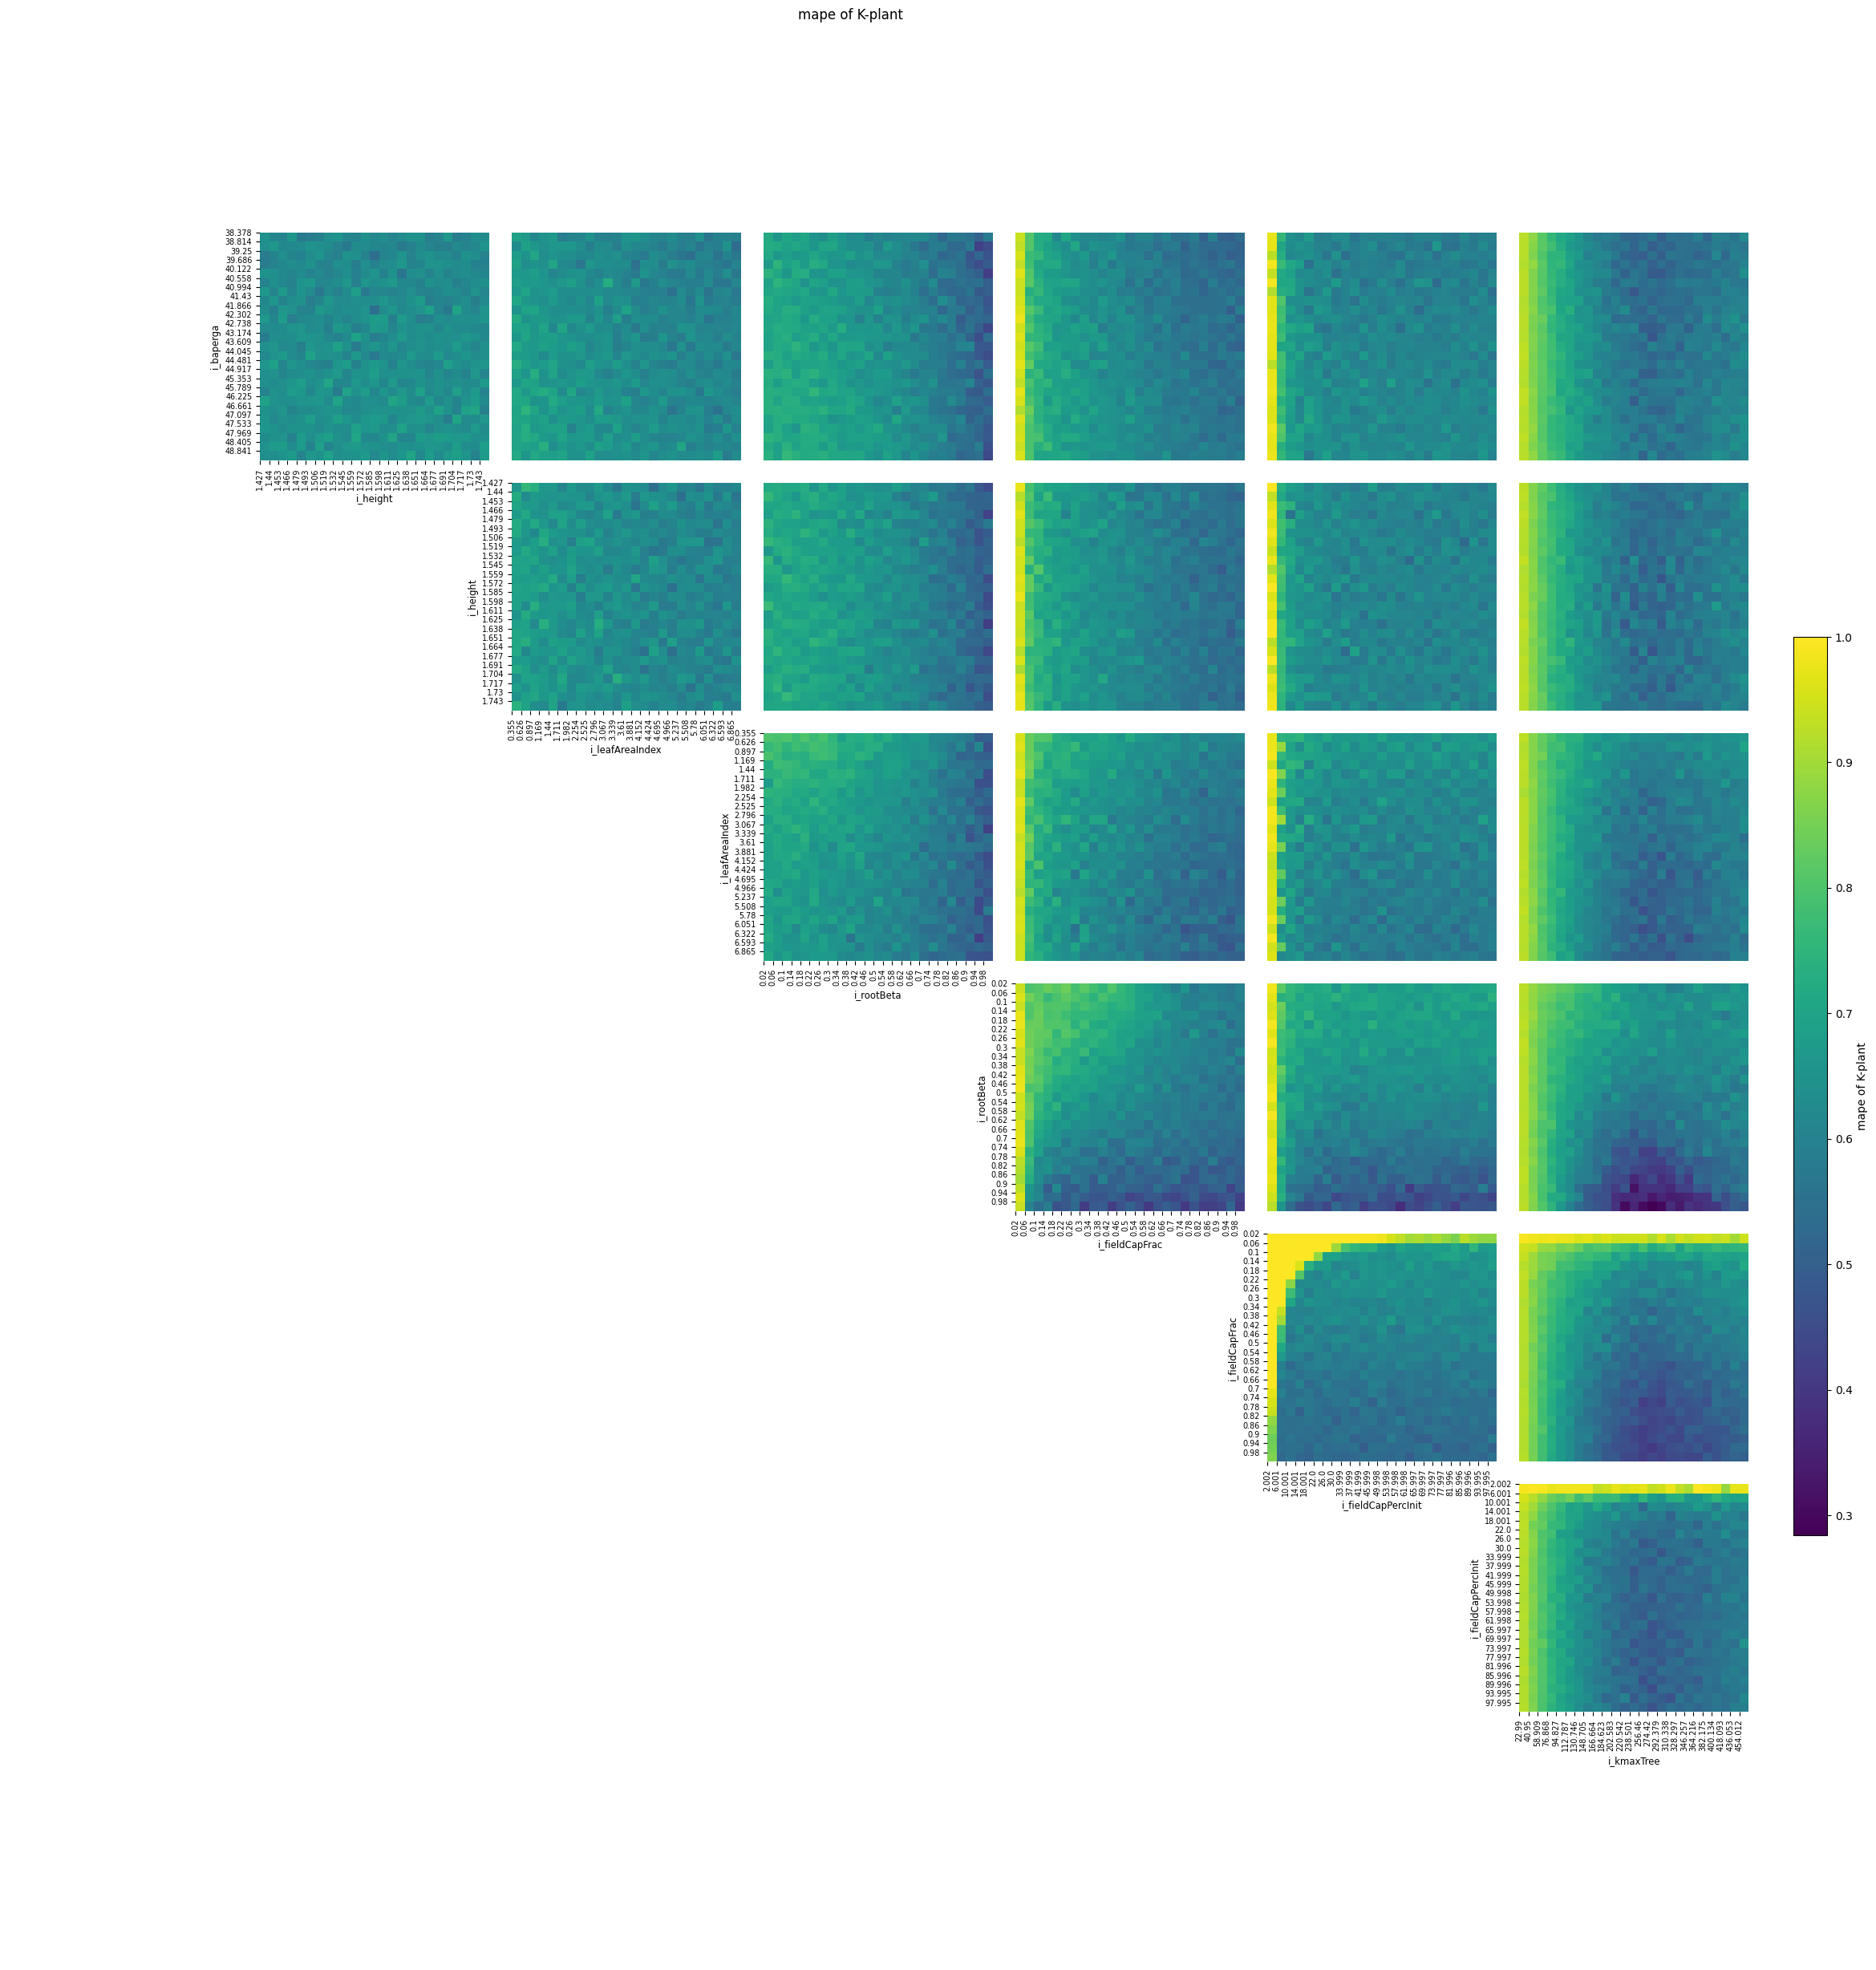

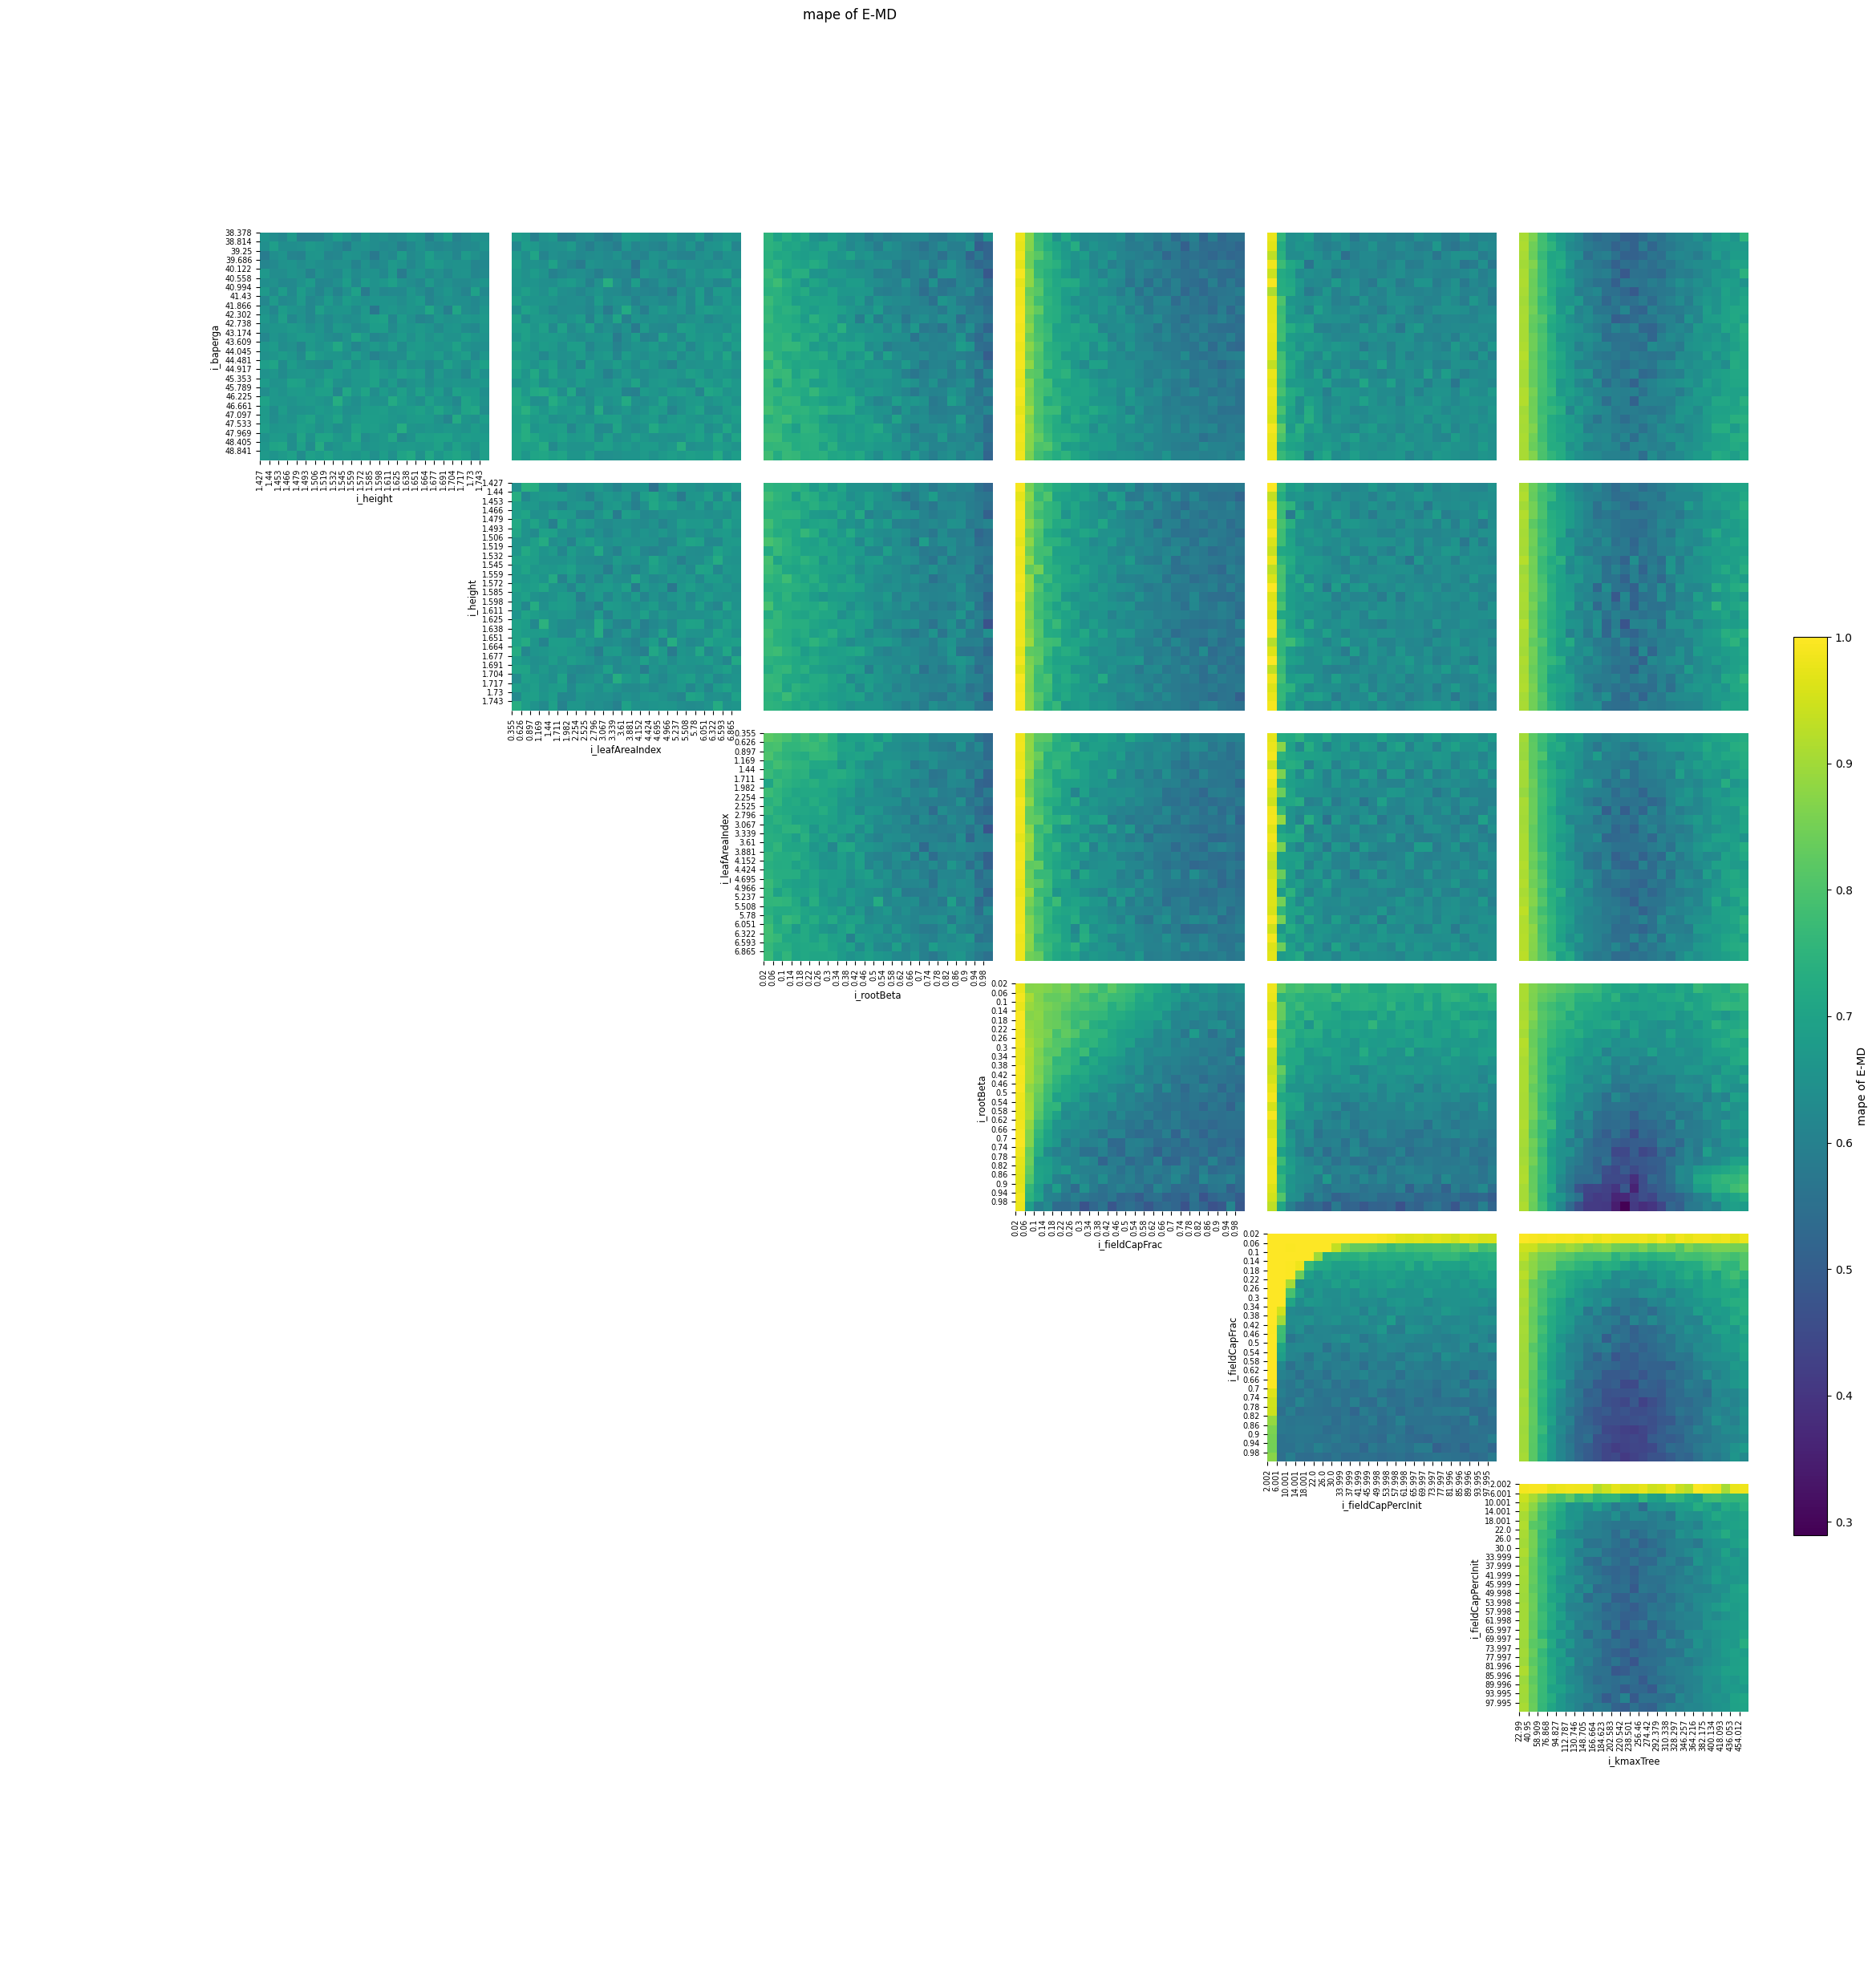

In [14]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

n_inputs = problem['num_vars']
figsize = 4

for d in range(D):

    col = problem['outputs'][d]
    z = errors[col][metric]

    vmin, vmax = np.inf, -np.inf  # Track global color limits
    stat_matrices = {}  # Cache stats for each pair

    # Precompute stats to determine global color scale
    for i in range(n_inputs):
        for j in range(n_inputs):
            if j <= i:
                continue
            x = sample[:, i]
            y = sample[:, j]
            stat, _, _, _ = binned_statistic_2d(x, y, z, statistic='mean', bins=bins)
            stat_matrices[(i, j)] = stat
            vmin = np.nanmin([vmin, np.nanmin(stat)])
            vmax = np.nanmax([vmax, np.nanmax(stat)])

    # Create plot grid
    fig, axes = plt.subplots(n_inputs, n_inputs, figsize=(figsize * n_inputs, figsize * n_inputs))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i in range(n_inputs):
        for j in range(n_inputs):
            ax = axes[i, j]

            if j <= i:
                ax.axis("off")
                continue

            x = sample[:, i]
            y = sample[:, j]
            stat = stat_matrices[(i, j)]
            x_edges = np.linspace(x.min(), x.max(), bins + 1)
            y_edges = np.linspace(y.min(), y.max(), bins + 1)

            # Heatmap
            sns.heatmap(
                stat,
                ax=ax,
                xticklabels=False,
                yticklabels=False,
                cmap='viridis',
                vmin=vmin,
                vmax=vmax,
                cbar=False
            )

            # Ticks
            step_x = max(1, len(x_edges) // max_ticks)
            x_tick_indices = np.arange(0, len(x_edges) - 1, step_x)
            x_tick_labels = np.round((x_edges[x_tick_indices] + x_edges[x_tick_indices + 1]) / 2, 3)

            step_y = max(1, len(y_edges) // max_ticks)
            y_tick_indices = np.arange(0, len(y_edges) - 1, step_y)
            y_tick_labels = np.round((y_edges[y_tick_indices] + y_edges[y_tick_indices + 1]) / 2, 3)

            if i == j - 1:
                ax.set_yticks(x_tick_indices)
                ax.set_yticklabels(x_tick_labels, fontsize='x-small', rotation=0)
            if j == i + 1:
                ax.set_xticks(y_tick_indices)
                ax.set_xticklabels(y_tick_labels, fontsize='x-small', rotation=90)

            if i == j - 1:
                ax.set_xlabel(problem["names"][j], fontsize="small")
            if j == i + 1:
                ax.set_ylabel(problem["names"][i], fontsize="small")

    # Add a single colorbar
    cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label=f"{metric} of {col}")

    plt.suptitle(f"{metric} of {problem["outputs"][d]}", fontsize="large")
    plt.show()

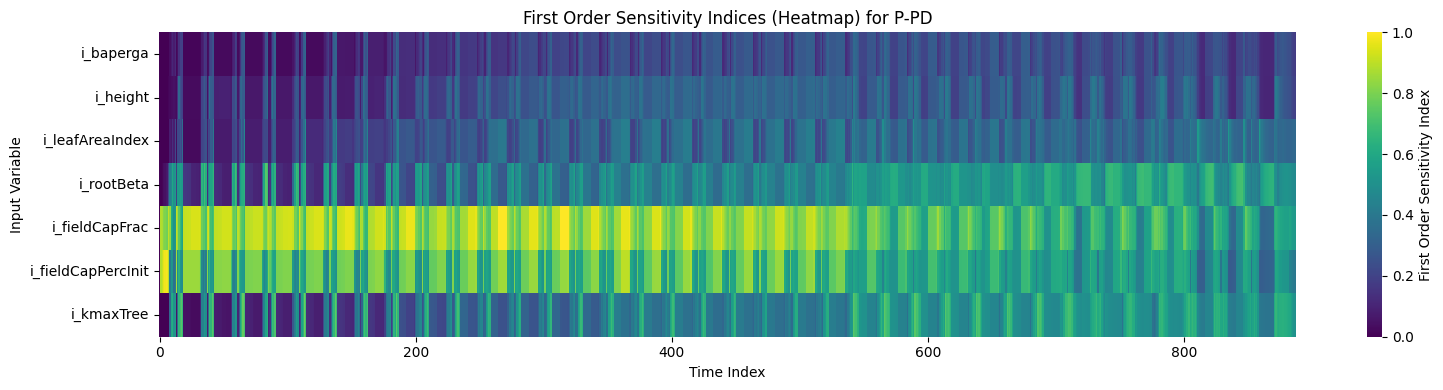

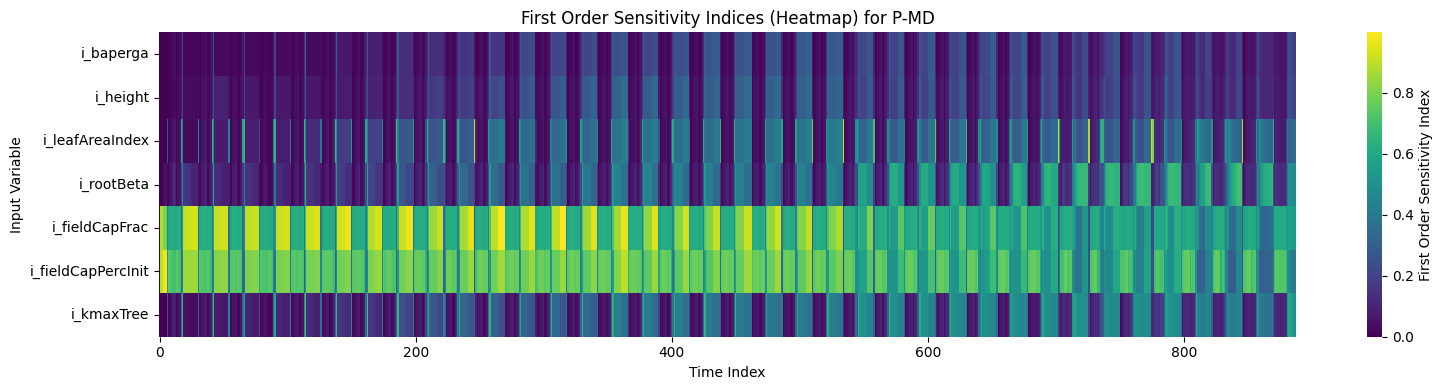

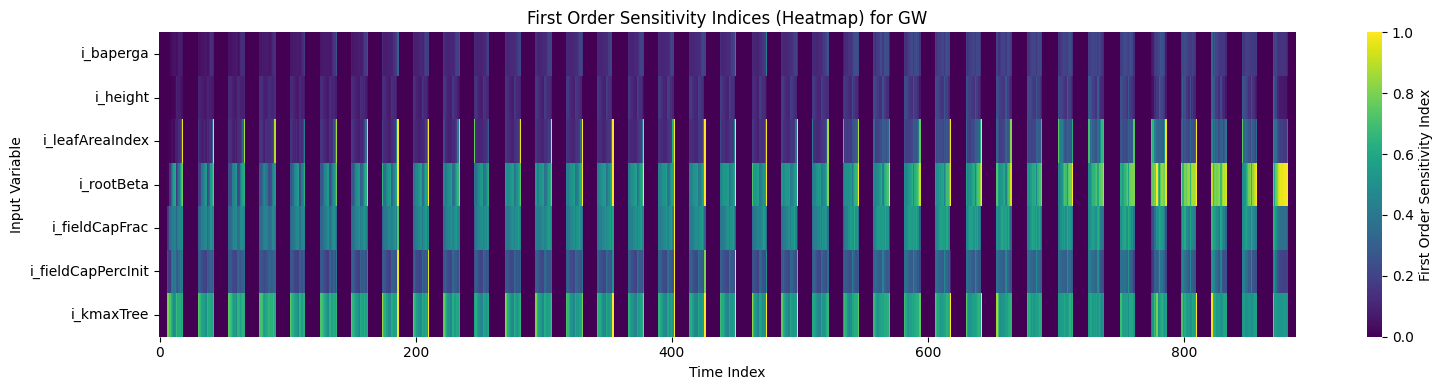

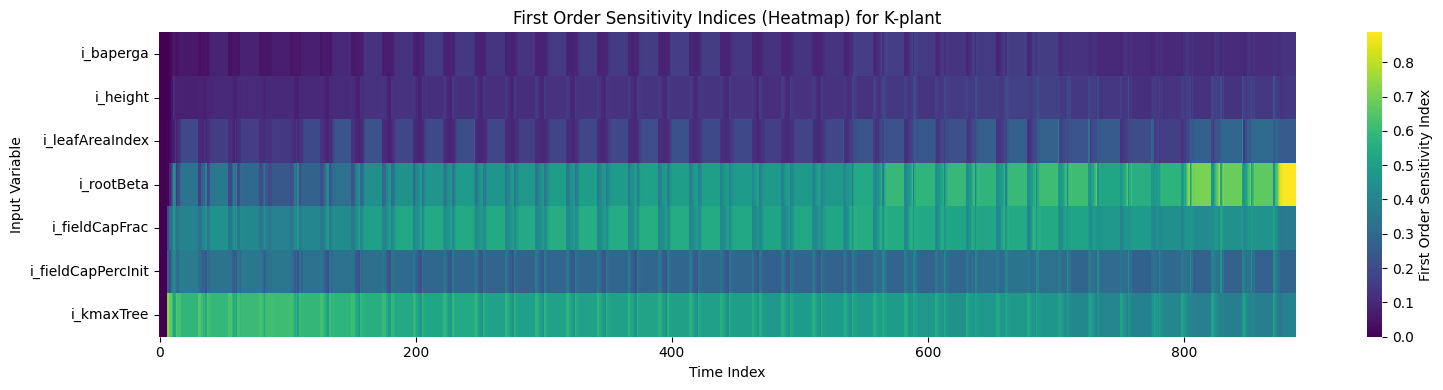

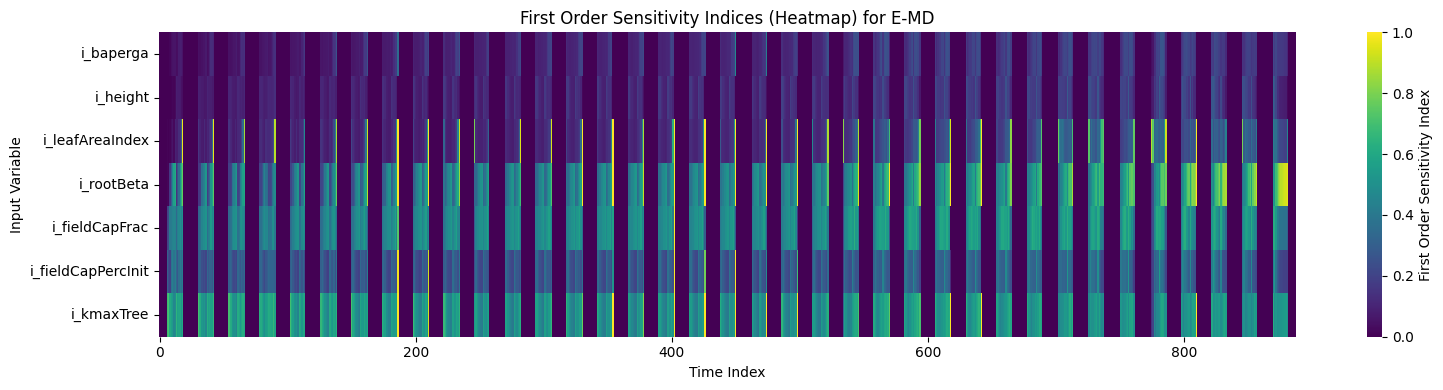

In [15]:
# Output SA Indices
for d in range(D):
    plt.figure(figsize=(16, 4))

    sns.heatmap(
        indices[d, :, t_range.start:t_range.stop],
        cmap='viridis',
        cbar_kws={'label': 'First Order Sensitivity Index'},
        xticklabels=200,
        yticklabels=problem['names']
    )
    plt.xlabel('Time Index')
    plt.ylabel('Input Variable')
    plt.title(f'First Order Sensitivity Indices (Heatmap) for {problem["outputs"][d]}')
    plt.tight_layout()
    plt.show()

<Figure size 1600x400 with 0 Axes>

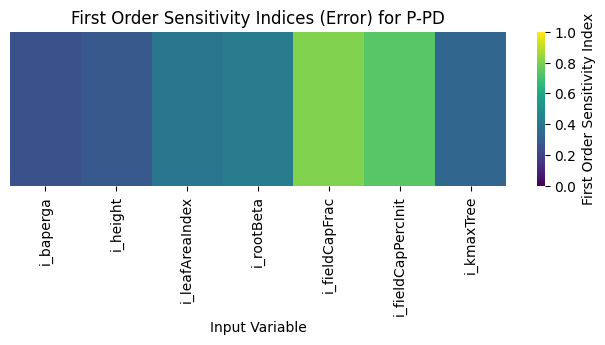

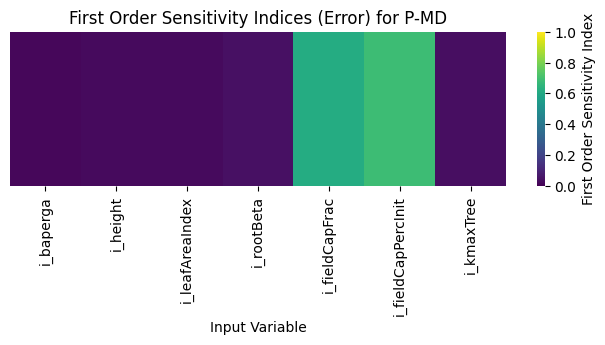

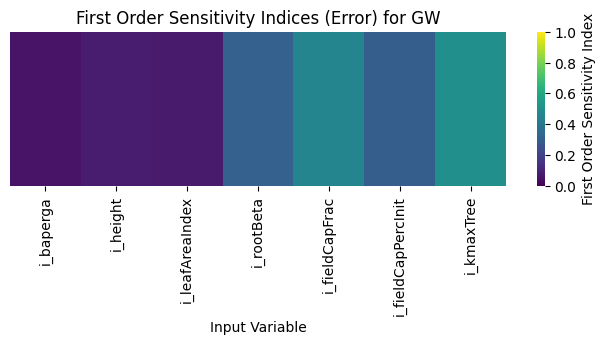

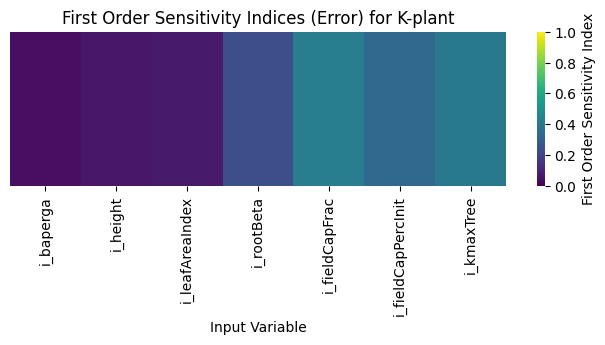

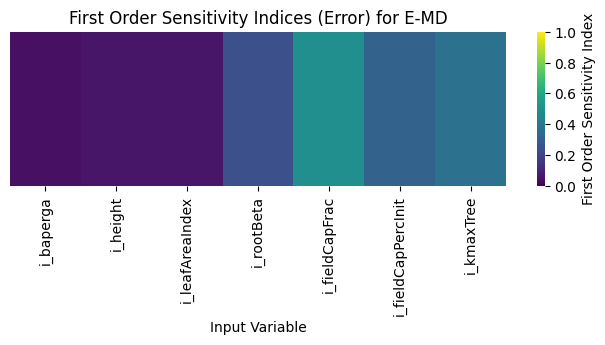

In [16]:
# Error SA Indices
plt.figure(figsize=(16, 4))

for d in range(D):
    plt.figure(figsize=(8, 2))
    sns.heatmap(
        error_indices[d, :].reshape(1, I),
        cmap='viridis',
        cbar_kws={'label': 'First Order Sensitivity Index'},
        vmin=0, vmax=1,
        xticklabels=problem['names'],
        yticklabels=False
    )
    plt.xlabel('Input Variable')
    plt.ylabel('')
    plt.title(f'First Order Sensitivity Indices (Error) for {problem["outputs"][d]}')
    plt.show()